In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reset -f

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import caffe
caffe.set_mode_gpu()

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/mukul/development/deepLearning/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/mukul/development/deepLearning/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/mukul/development/deepLearning/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion meth

In [2]:
import python.helpers as helpers

In [3]:
trainingLogFile = "logs/train_sunset.log"
modelPrototxt = "models/sunset_train_test.prototxt"
solverPrototxt = "models/sunset_solver.prototxt"
trainedModel = "snapshots/sunset_iter_10000.caffemodel"

In [7]:
#Train the net
os.system("bash run_training_pipeline.sh Sunset")

0

In [38]:
net = caffe.Net(modelPrototxt, trainedModel, caffe.TEST)

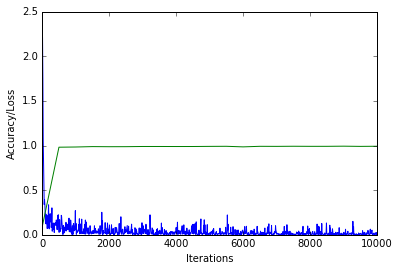

Baseline loss 2.34909
Baseline accuracy 0.0893


In [39]:
#Show training graph
iterations, losses = helpers.getLossFromTrainingFile(trainingLogFile)
plt.plot(iterations, losses)

iterations, accuracy = helpers.getAccuracyFromTrainingFile(trainingLogFile)
plt.plot(iterations, accuracy)
plt.xlabel("Iterations")
plt.ylabel("Accuracy/Loss")

plt.show()

print "Baseline loss " + losses[0]
print "Baseline accuracy " + accuracy[0]

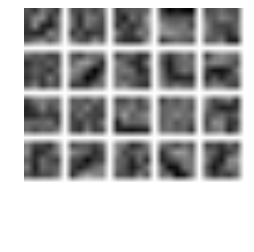

In [40]:
#Visualize learned filters from first layer
filters = net.params["conv1"][0].data
helpers.showFilterGrid(filters.transpose(0, 2, 3, 1), True)